In [1]:
%run "E:\Users\puzheng\Documents\Startup_py3.py"
sys.path.append(r"E:\Users\puzheng\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

16496


# 0. required packages for h5py

In [2]:
import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

# 1. Create field-of-view class

In [3]:
reload(ia)
reload(classes)
reload(classes.batch_functions)
reload(classes.field_of_view)
reload(io_tools.load)

reload(visual_tools)
reload(ia.correction_tools)
reload(ia.correction_tools.alignment)
reload(ia.spot_tools.matching)
reload(ia.segmentation_tools.chromosome)
reload(ia.spot_tools.fitting)

fov_param = {'data_folder':r'\\10.245.74.158\Chromatin_NAS_6\20200920-B_DMSO_CTP-08_IgH',
             'save_folder':r'I:\Pu_Temp\202009_IgH_proB_DMSO_2color',
             #'save_folder':r'D:\Pu_Temp\202009_IgH_proB_DMSO_2color',
             'experiment_type': 'DNA',
             'num_threads': 24,
             'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20201012-Corrections_2color',
             'shared_parameters':{
                     'single_im_size':[35,2048,2048],
                     'corr_channels':['750','647'],
                     'num_empty_frames': 0, 
                     'corr_hot_pixel':True,
                     'corr_Z_shift':False,
                     'min_num_seeds':500,
                     'max_num_seeds': 2500,
                     'spot_seeding_th':125,
                     'normalize_intensity_local':True,
                     'normalize_intensity_background':False,
                 },             
             }

fov_ids = np.arange(4,23)

In [4]:
reload(io_tools.load)
from ImageAnalysis3.spot_tools.picking import assign_spots_to_chromosomes
overwrite=False
intensity_th = 0.5

spots_list_list = []
chrom_coords_list = []
cand_chr_spots_list = []

for _fov_id in fov_ids:

    # create fov class
    fov = classes.field_of_view.Field_of_View(fov_param, _fov_id=_fov_id,
                                              _color_info_kwargs={
                                                  '_color_filename':'Color_Usage',
                                              }, 
                                              _prioritize_saved_attrs=False,
                                              )

    # process image into spots
    id_list, spot_list = fov._process_image_to_spots('unique', 
                                                     _load_common_reference=True,
                                                     _load_with_multiple=False,
                                                     _save_images=True,
                                                     _warp_images=False, 
                                                     _overwrite_drift=False,
                                                     _overwrite_image=False,
                                                     _overwrite_spot=overwrite,
                                                     _verbose=True)
    # identify chromosomes
    chrom_im = fov._load_chromosome_image(_overwrite=overwrite)
    chrom_coords = fov._find_candidate_chromosomes_by_segmentation(_filt_size=4, _binary_per_th=99.5, _overwrite=overwrite)
    fov._load_from_file('unique')
    chrom_coords = fov._select_chromosome_by_candidate_spots(
        _good_chr_loss_th=0.25, _overwrite=overwrite,
        _save=True)
    
    # append
    spots_list_list.append(fov.unique_spots_list)
    chrom_coords_list.append(fov.chrom_coords)
    
    fov_cand_chr_spots_list = [[] for _ct in fov.chrom_coords]

    # finalize candidate spots
    for _spots in fov.unique_spots_list:
        _cands_list = assign_spots_to_chromosomes(_spots, fov.chrom_coords)
        for _i, _cands in enumerate(_cands_list):
            fov_cand_chr_spots_list[_i].append(_cands)
            
    cand_chr_spots_list += fov_cand_chr_spots_list
    
    print(f"kept chromosomes: {len(fov.chrom_coords)}")

# combine acquired spots and chromosomes
chrom_coords = np.concatenate(chrom_coords_list)

from ImageAnalysis3.spot_tools.picking import convert_spots_to_hzxys
dna_cand_hzxys_list = [convert_spots_to_hzxys(_spots, fov.shared_parameters['distance_zxy'])
                       for _spots in cand_chr_spots_list]
dna_reg_ids = fov.unique_ids

print(f"{len(chrom_coords)} are found.")

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 74
- Number of field of views: 64
- Importing csv file: \\10.245.74.158\Chromatin_NAS_6\20200920-B_DMSO_CTP-08_IgH\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 73 folders are found according to color-usage annotation.
++ load bleed correction profile from original file.
-- loading bleedthrough correction profile from file:bleedthrough_correction_750_647_2048_2048.npy
++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048.npy
	 647 None
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048_const.pkl
	 647 None
++ load illumination correction profile from original file.
-- loading illumination correction profile fr

 376 377 379 380 381 382 383 384 386 387 388 389 390 391 392 393 394 395] in 1975.19s.
-- choose chrom images from folder: \.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_6\20200920-B_DMSO_CTP-08_IgH\H0R0\Conv_zscan_04.dax
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048.npy
	 647 None
-- loading image from file:\\10.245.74.158\Chromatin_NAS_6\20200920-B_DMSO_CTP-08_IgH\H0R0\Conv_zscan_04.dax  in 19.586s
-- removing hot pixels for channels:['750'] in 13.761s
-- illumination correction for channels: 750, in 2.978s
-- warp image with chromatic correction for channels: ['750'] and drift:[0. 0. 0.] 750, in 85.358s
-- finish correction in 132.593s
-- chromosome image has drift: [0. 0. 0.]
-- saving fov_info to file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_04.hdf5
++ base attributes saved:['chrom_im'] in 5.316s.


E:\Users\puzheng\Documents\ImageAnalysis3\segmentation_tools\chromosome.py:79: UserWarning: Random walker only segments unlabeled areas, where labels == 0. No zero valued areas in labels were found. Returning provided labels.
  _seg_label = random_walker(adj_chrom_im, _label, beta=10, mode='cg_mg')


-- find objects larger than size=50
-- 762 objects are found by segmentation.
- Start multiprocessing caluclate chromosome coordinates with 24 threads in 701.664s.
-- saving fov_info to file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_04.hdf5
++ base attributes saved:['cand_chrom_coords'] in 0.022s.
+ loading unique from file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_04.hdf5
++ finish loading unique in 0.044s. 
+ loading fov_info from file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_04.hdf5
++ base attributes loaded:[] in 1.231s.
- start select from 762 chromosomes with loss threshold=0.25
-- remove chr id 548, percentage of lost rounds:0.896.
-- remove chr id 662, percentage of lost rounds:0.840.
-- remove chr id 325, percentage of lost rounds:0.743.
-- remove chr id 696, percentage of lost rounds:0.736.
-- remove chr id 432, percentage of lost rounds:0.653.
-- remove chr id 509, percentage of lost rounds:0.632.
-- remove chr id 182, percentage of lost rounds:0.

-- remove chr id 82, percentage of lost rounds:0.292.
-- remove chr id 86, percentage of lost rounds:0.292.
-- remove chr id 110, percentage of lost rounds:0.292.
-- remove chr id 122, percentage of lost rounds:0.292.
-- remove chr id 140, percentage of lost rounds:0.292.
-- remove chr id 338, percentage of lost rounds:0.292.
-- remove chr id 566, percentage of lost rounds:0.292.
-- remove chr id 35, percentage of lost rounds:0.285.
-- remove chr id 58, percentage of lost rounds:0.285.
-- remove chr id 79, percentage of lost rounds:0.285.
-- remove chr id 111, percentage of lost rounds:0.285.
-- remove chr id 199, percentage of lost rounds:0.285.
-- remove chr id 333, percentage of lost rounds:0.285.
-- remove chr id 417, percentage of lost rounds:0.285.
-- remove chr id 184, percentage of lost rounds:0.278.
-- remove chr id 247, percentage of lost rounds:0.278.
-- remove chr id 295, percentage of lost rounds:0.278.
-- remove chr id 349, percentage of lost rounds:0.278.
-- remove chr i

-- checking unique, region:[351 349] in 0.008s.
-- checking unique, region:[354 352] in 0.007s.
-- checking unique, region:[357 355] in 0.007s.
-- checking unique, region:[360 358] in 0.007s.
-- checking unique, region:[363 361] in 0.007s.
-- checking unique, region:[366 364] in 0.007s.
-- checking unique, region:[369 367] in 0.007s.
-- checking unique, region:[372 370] in 0.007s.
-- checking unique, region:[375 373] in 0.007s.
-- checking unique, region:[379 376] in 0.007s.
-- checking unique, region:[382 380] in 0.007s.
-- checking unique, region:[388 383] in 0.007s.
-- checking unique, region:[391 386] in 0.007s.
-- checking unique, region:[394 389] in 0.007s.
-- checking unique, region:[ 43 392] in 0.007s.
-- checking unique, region:[ 49 395] in 0.007s.
-- checking unique, region:[55 46] in 0.007s.
-- checking unique, region:[62 52] in 0.007s.
-- checking unique, region:[68 59] in 0.007s.
-- checking unique, region:[74 65] in 0.007s.
-- checking unique, region:[80 71] in 0.007s.
--

-- remove chr id 503, percentage of lost rounds:0.382.
-- remove chr id 226, percentage of lost rounds:0.375.
-- remove chr id 232, percentage of lost rounds:0.375.
-- remove chr id 66, percentage of lost rounds:0.368.
-- remove chr id 75, percentage of lost rounds:0.368.
-- remove chr id 110, percentage of lost rounds:0.368.
-- remove chr id 179, percentage of lost rounds:0.368.
-- remove chr id 193, percentage of lost rounds:0.368.
-- remove chr id 24, percentage of lost rounds:0.361.
-- remove chr id 70, percentage of lost rounds:0.361.
-- remove chr id 85, percentage of lost rounds:0.361.
-- remove chr id 163, percentage of lost rounds:0.361.
-- remove chr id 19, percentage of lost rounds:0.354.
-- remove chr id 56, percentage of lost rounds:0.354.
-- remove chr id 68, percentage of lost rounds:0.354.
-- remove chr id 451, percentage of lost rounds:0.354.
-- remove chr id 457, percentage of lost rounds:0.354.
-- remove chr id 586, percentage of lost rounds:0.354.
-- remove chr id 7

-- saving 647_illumination profile to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_06.hdf5.
-- saving 488_illumination profile to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_06.hdf5.
-- saving 405_illumination profile to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_06.hdf5.
-- saving 750_chromatic profile to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_06.hdf5.
-- saving 647_chromatic profile to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_06.hdf5.
-- saving 750_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_06.hdf5.
-- 647_chromatic_constants profile already exist in save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_06.hdf5, skip.
-- saving 750_647_bleed profile to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_06.hdf5.
-- saving unique to file: I:\Pu_Temp\202009_IgH_proB_DM

++ base attributes loaded:[] in 1.215s.
- start select from 670 chromosomes with loss threshold=0.25
-- remove chr id 331, percentage of lost rounds:0.812.
-- remove chr id 491, percentage of lost rounds:0.750.
-- remove chr id 569, percentage of lost rounds:0.736.
-- remove chr id 530, percentage of lost rounds:0.729.
-- remove chr id 310, percentage of lost rounds:0.715.
-- remove chr id 107, percentage of lost rounds:0.701.
-- remove chr id 489, percentage of lost rounds:0.694.
-- remove chr id 614, percentage of lost rounds:0.688.
-- remove chr id 296, percentage of lost rounds:0.674.
-- remove chr id 648, percentage of lost rounds:0.660.
-- remove chr id 278, percentage of lost rounds:0.653.
-- remove chr id 464, percentage of lost rounds:0.646.
-- remove chr id 395, percentage of lost rounds:0.618.
-- remove chr id 527, percentage of lost rounds:0.583.
-- remove chr id 359, percentage of lost rounds:0.542.
-- remove chr id 543, percentage of lost rounds:0.528.
-- remove chr id 64

kept chromosomes: 522
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 74
- Number of field of views: 64
- Importing csv file: \\10.245.74.158\Chromatin_NAS_6\20200920-B_DMSO_CTP-08_IgH\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 73 folders are found according to color-usage annotation.
++ load bleed correction profile from original file.
-- loading bleedthrough correction profile from file:bleedthrough_correction_750_647_2048_2048.npy
++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048.npy
	 647 None
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048_const.pkl
	 647 None
++ load illumination correction profile from original file.
-- loading illumination

 376 377 379 380 381 382 383 384 386 387 388 389 390 391 392 393 394 395] in 1853.37s.
-- choose chrom images from folder: \.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_6\20200920-B_DMSO_CTP-08_IgH\H0R0\Conv_zscan_07.dax
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048.npy
	 647 None
-- loading image from file:\\10.245.74.158\Chromatin_NAS_6\20200920-B_DMSO_CTP-08_IgH\H0R0\Conv_zscan_07.dax  in 10.197s
-- removing hot pixels for channels:['750'] in 11.898s
-- illumination correction for channels: 750, in 2.374s
-- warp image with chromatic correction for channels: ['750'] and drift:[0. 0. 0.] 750, in 88.278s
-- finish correction in 123.938s
-- chromosome image has drift: [0. 0. 0.]
-- saving fov_info to file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_07.hdf5
++ base attributes saved:['chrom_im'] in 5.415s.


-- remove chr id 341, percentage of lost rounds:0.292.
-- remove chr id 590, percentage of lost rounds:0.292.
-- remove chr id 22, percentage of lost rounds:0.285.
-- remove chr id 40, percentage of lost rounds:0.285.
-- remove chr id 68, percentage of lost rounds:0.285.
-- remove chr id 69, percentage of lost rounds:0.285.
-- remove chr id 114, percentage of lost rounds:0.285.
-- remove chr id 123, percentage of lost rounds:0.285.
-- remove chr id 164, percentage of lost rounds:0.285.
-- remove chr id 203, percentage of lost rounds:0.285.
-- remove chr id 228, percentage of lost rounds:0.285.
-- remove chr id 346, percentage of lost rounds:0.285.
-- remove chr id 33, percentage of lost rounds:0.278.
-- remove chr id 84, percentage of lost rounds:0.278.
-- remove chr id 93, percentage of lost rounds:0.278.
-- remove chr id 311, percentage of lost rounds:0.278.
-- remove chr id 538, percentage of lost rounds:0.278.
-- remove chr id 545, percentage of lost rounds:0.278.
-- remove chr id 

-- checking unique, region:[326 324] in 0.007s.
-- checking unique, region:[329 327] in 0.008s.
-- checking unique, region:[332 330] in 0.007s.
-- checking unique, region:[335 333] in 0.007s.
-- checking unique, region:[339 337] in 0.007s.
-- checking unique, region:[342 340] in 0.007s.
-- checking unique, region:[345 343] in 0.006s.
-- checking unique, region:[348 346] in 0.008s.
-- checking unique, region:[351 349] in 0.006s.
-- checking unique, region:[354 352] in 0.006s.
-- checking unique, region:[357 355] in 0.006s.
-- checking unique, region:[360 358] in 0.007s.
-- checking unique, region:[363 361] in 0.007s.
-- checking unique, region:[366 364] in 0.007s.
-- checking unique, region:[369 367] in 0.007s.
-- checking unique, region:[372 370] in 0.006s.
-- checking unique, region:[375 373] in 0.006s.
-- checking unique, region:[379 376] in 0.006s.
-- checking unique, region:[382 380] in 0.007s.
-- checking unique, region:[388 383] in 0.007s.
-- checking unique, region:[391 386] in 

-- remove chr id 321, percentage of lost rounds:0.410.
-- remove chr id 531, percentage of lost rounds:0.410.
-- remove chr id 48, percentage of lost rounds:0.403.
-- remove chr id 82, percentage of lost rounds:0.403.
-- remove chr id 337, percentage of lost rounds:0.403.
-- remove chr id 13, percentage of lost rounds:0.396.
-- remove chr id 35, percentage of lost rounds:0.396.
-- remove chr id 134, percentage of lost rounds:0.396.
-- remove chr id 264, percentage of lost rounds:0.396.
-- remove chr id 405, percentage of lost rounds:0.396.
-- remove chr id 276, percentage of lost rounds:0.389.
-- remove chr id 456, percentage of lost rounds:0.389.
-- remove chr id 50, percentage of lost rounds:0.382.
-- remove chr id 81, percentage of lost rounds:0.382.
-- remove chr id 137, percentage of lost rounds:0.382.
-- remove chr id 137, percentage of lost rounds:0.382.
-- remove chr id 173, percentage of lost rounds:0.382.
-- remove chr id 263, percentage of lost rounds:0.382.
-- remove chr id

-- saving 647_illumination profile to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_09.hdf5.
-- saving 488_illumination profile to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_09.hdf5.
-- saving 405_illumination profile to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_09.hdf5.
-- saving 750_chromatic profile to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_09.hdf5.
-- saving 647_chromatic profile to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_09.hdf5.
-- saving 750_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_09.hdf5.
-- 647_chromatic_constants profile already exist in save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_09.hdf5, skip.
-- saving 750_647_bleed profile to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_09.hdf5.
-- saving unique to file: I:\Pu_Temp\202009_IgH_proB_DM

++ base attributes loaded:[] in 1.244s.
- start select from 778 chromosomes with loss threshold=0.25
-- remove chr id 773, percentage of lost rounds:0.861.
-- remove chr id 224, percentage of lost rounds:0.694.
-- remove chr id 529, percentage of lost rounds:0.604.
-- remove chr id 388, percentage of lost rounds:0.590.
-- remove chr id 700, percentage of lost rounds:0.590.
-- remove chr id 131, percentage of lost rounds:0.583.
-- remove chr id 559, percentage of lost rounds:0.576.
-- remove chr id 474, percentage of lost rounds:0.549.
-- remove chr id 192, percentage of lost rounds:0.514.
-- remove chr id 521, percentage of lost rounds:0.507.
-- remove chr id 229, percentage of lost rounds:0.500.
-- remove chr id 68, percentage of lost rounds:0.493.
-- remove chr id 706, percentage of lost rounds:0.493.
-- remove chr id 706, percentage of lost rounds:0.486.
-- remove chr id 89, percentage of lost rounds:0.479.
-- remove chr id 115, percentage of lost rounds:0.479.
-- remove chr id 83, 

-- remove chr id 21, percentage of lost rounds:0.271.
-- remove chr id 33, percentage of lost rounds:0.271.
-- remove chr id 233, percentage of lost rounds:0.271.
-- remove chr id 318, percentage of lost rounds:0.271.
-- remove chr id 477, percentage of lost rounds:0.271.
-- remove chr id 598, percentage of lost rounds:0.271.
-- remove chr id 167, percentage of lost rounds:0.264.
-- remove chr id 219, percentage of lost rounds:0.264.
-- remove chr id 261, percentage of lost rounds:0.264.
-- remove chr id 305, percentage of lost rounds:0.264.
-- remove chr id 349, percentage of lost rounds:0.264.
-- remove chr id 366, percentage of lost rounds:0.264.
-- remove chr id 486, percentage of lost rounds:0.264.
-- remove chr id 612, percentage of lost rounds:0.264.
-- remove chr id 23, percentage of lost rounds:0.257.
-- remove chr id 81, percentage of lost rounds:0.257.
-- remove chr id 112, percentage of lost rounds:0.257.
-- remove chr id 121, percentage of lost rounds:0.257.
-- remove chr 

-- checking unique, region:[74 65] in 0.007s.
-- checking unique, region:[80 71] in 0.008s.
-- checking unique, region:[86 77] in 0.007s.
-- checking unique, region:[92 83] in 0.007s.
-- checking unique, region:[98 89] in 0.007s.
-- checking unique, region:[104  95] in 0.008s.
-- checking unique, region:[110 101] in 0.007s.
-- checking unique, region:[325 107] in 0.007s.
-- checking unique, region:[331 113] in 0.007s.
-- checking unique, region:[341 328] in 0.007s.
-- checking unique, region:[347 334] in 0.007s.
-- checking unique, region:[353 344] in 0.007s.
-- checking unique, region:[359 350] in 0.007s.
-- checking unique, region:[365 356] in 0.007s.
-- checking unique, region:[371 362] in 0.007s.
-- checking unique, region:[377 368] in 0.007s.
-- checking unique, region:[384 374] in 0.007s.
-- checking unique, region:[390 381] in 0.007s.
-- checking unique, region:[393 387] in 0.007s.
+ Start multi-processing of pre-processing for 72 images with 24 threads
++ processed unique ids: 

-- remove chr id 375, percentage of lost rounds:0.375.
-- remove chr id 432, percentage of lost rounds:0.375.
-- remove chr id 451, percentage of lost rounds:0.375.
-- remove chr id 113, percentage of lost rounds:0.368.
-- remove chr id 143, percentage of lost rounds:0.368.
-- remove chr id 150, percentage of lost rounds:0.368.
-- remove chr id 240, percentage of lost rounds:0.368.
-- remove chr id 352, percentage of lost rounds:0.368.
-- remove chr id 105, percentage of lost rounds:0.361.
-- remove chr id 206, percentage of lost rounds:0.361.
-- remove chr id 463, percentage of lost rounds:0.361.
-- remove chr id 37, percentage of lost rounds:0.354.
-- remove chr id 53, percentage of lost rounds:0.354.
-- remove chr id 107, percentage of lost rounds:0.354.
-- remove chr id 208, percentage of lost rounds:0.354.
-- remove chr id 388, percentage of lost rounds:0.354.
-- remove chr id 28, percentage of lost rounds:0.347.
-- remove chr id 95, percentage of lost rounds:0.347.
-- remove chr 

-- saving 750_illumination profile to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_11.hdf5.
-- saving 647_illumination profile to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_11.hdf5.
-- saving 488_illumination profile to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_11.hdf5.
-- saving 405_illumination profile to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_11.hdf5.
-- saving 750_chromatic profile to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_11.hdf5.
-- saving 647_chromatic profile to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_11.hdf5.
-- saving 750_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_11.hdf5.
-- 647_chromatic_constants profile already exist in save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_11.hdf5, skip.
-- saving 750_647_bleed profile to save_file: I:\Pu_

++ base attributes loaded:[] in 1.457s.
- start select from 762 chromosomes with loss threshold=0.25
-- remove chr id 487, percentage of lost rounds:0.889.
-- remove chr id 182, percentage of lost rounds:0.826.
-- remove chr id 303, percentage of lost rounds:0.799.
-- remove chr id 250, percentage of lost rounds:0.792.
-- remove chr id 703, percentage of lost rounds:0.750.
-- remove chr id 683, percentage of lost rounds:0.736.
-- remove chr id 213, percentage of lost rounds:0.715.
-- remove chr id 264, percentage of lost rounds:0.708.
-- remove chr id 675, percentage of lost rounds:0.667.
-- remove chr id 87, percentage of lost rounds:0.639.
-- remove chr id 739, percentage of lost rounds:0.639.
-- remove chr id 546, percentage of lost rounds:0.632.
-- remove chr id 134, percentage of lost rounds:0.611.
-- remove chr id 179, percentage of lost rounds:0.611.
-- remove chr id 111, percentage of lost rounds:0.583.
-- remove chr id 579, percentage of lost rounds:0.562.
-- remove chr id 646

-- remove chr id 510, percentage of lost rounds:0.340.
-- remove chr id 609, percentage of lost rounds:0.340.
-- remove chr id 46, percentage of lost rounds:0.333.
-- remove chr id 92, percentage of lost rounds:0.333.
-- remove chr id 129, percentage of lost rounds:0.333.
-- remove chr id 162, percentage of lost rounds:0.333.
-- remove chr id 177, percentage of lost rounds:0.333.
-- remove chr id 300, percentage of lost rounds:0.333.
-- remove chr id 339, percentage of lost rounds:0.333.
-- remove chr id 446, percentage of lost rounds:0.333.
-- remove chr id 461, percentage of lost rounds:0.333.
-- remove chr id 518, percentage of lost rounds:0.333.
-- remove chr id 535, percentage of lost rounds:0.333.
-- remove chr id 559, percentage of lost rounds:0.333.
-- remove chr id 577, percentage of lost rounds:0.333.
-- remove chr id 91, percentage of lost rounds:0.326.
-- remove chr id 101, percentage of lost rounds:0.326.
-- remove chr id 114, percentage of lost rounds:0.326.
-- remove chr

-- saving 647_illumination profile to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_12.hdf5.
-- saving 488_illumination profile to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_12.hdf5.
-- saving 405_illumination profile to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_12.hdf5.
-- saving 750_chromatic profile to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_12.hdf5.
-- saving 647_chromatic profile to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_12.hdf5.
-- saving 750_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_12.hdf5.
-- 647_chromatic_constants profile already exist in save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_12.hdf5, skip.
-- saving 750_647_bleed profile to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_12.hdf5.
-- saving unique to file: I:\Pu_Temp\202009_IgH_proB_DM

++ base attributes loaded:[] in 1.234s.
- start select from 732 chromosomes with loss threshold=0.25
-- remove chr id 723, percentage of lost rounds:0.903.
-- remove chr id 549, percentage of lost rounds:0.826.
-- remove chr id 517, percentage of lost rounds:0.757.
-- remove chr id 595, percentage of lost rounds:0.729.
-- remove chr id 108, percentage of lost rounds:0.722.
-- remove chr id 556, percentage of lost rounds:0.722.
-- remove chr id 400, percentage of lost rounds:0.688.
-- remove chr id 706, percentage of lost rounds:0.688.
-- remove chr id 89, percentage of lost rounds:0.611.
-- remove chr id 591, percentage of lost rounds:0.611.
-- remove chr id 411, percentage of lost rounds:0.597.
-- remove chr id 14, percentage of lost rounds:0.590.
-- remove chr id 165, percentage of lost rounds:0.583.
-- remove chr id 258, percentage of lost rounds:0.583.
-- remove chr id 42, percentage of lost rounds:0.569.
-- remove chr id 160, percentage of lost rounds:0.569.
-- remove chr id 459, 

-- remove chr id 518, percentage of lost rounds:0.347.
-- remove chr id 40, percentage of lost rounds:0.340.
-- remove chr id 87, percentage of lost rounds:0.340.
-- remove chr id 140, percentage of lost rounds:0.340.
-- remove chr id 140, percentage of lost rounds:0.340.
-- remove chr id 144, percentage of lost rounds:0.340.
-- remove chr id 171, percentage of lost rounds:0.340.
-- remove chr id 213, percentage of lost rounds:0.340.
-- remove chr id 230, percentage of lost rounds:0.340.
-- remove chr id 268, percentage of lost rounds:0.340.
-- remove chr id 505, percentage of lost rounds:0.340.
-- remove chr id 30, percentage of lost rounds:0.333.
-- remove chr id 54, percentage of lost rounds:0.333.
-- remove chr id 83, percentage of lost rounds:0.333.
-- remove chr id 112, percentage of lost rounds:0.333.
-- remove chr id 170, percentage of lost rounds:0.333.
-- remove chr id 178, percentage of lost rounds:0.333.
-- remove chr id 221, percentage of lost rounds:0.333.
-- remove chr i

-- saving 647_illumination profile to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_13.hdf5.
-- saving 488_illumination profile to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_13.hdf5.
-- saving 405_illumination profile to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_13.hdf5.
-- saving 750_chromatic profile to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_13.hdf5.
-- saving 647_chromatic profile to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_13.hdf5.
-- saving 750_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_13.hdf5.
-- 647_chromatic_constants profile already exist in save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_13.hdf5, skip.
-- saving 750_647_bleed profile to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_13.hdf5.
-- saving unique to file: I:\Pu_Temp\202009_IgH_proB_DM

++ base attributes loaded:[] in 1.225s.
- start select from 770 chromosomes with loss threshold=0.25
-- remove chr id 3, percentage of lost rounds:0.931.
-- remove chr id 731, percentage of lost rounds:0.799.
-- remove chr id 751, percentage of lost rounds:0.799.
-- remove chr id 377, percentage of lost rounds:0.764.
-- remove chr id 758, percentage of lost rounds:0.764.
-- remove chr id 421, percentage of lost rounds:0.715.
-- remove chr id 688, percentage of lost rounds:0.715.
-- remove chr id 145, percentage of lost rounds:0.694.
-- remove chr id 322, percentage of lost rounds:0.688.
-- remove chr id 680, percentage of lost rounds:0.646.
-- remove chr id 278, percentage of lost rounds:0.639.
-- remove chr id 399, percentage of lost rounds:0.632.
-- remove chr id 442, percentage of lost rounds:0.632.
-- remove chr id 3, percentage of lost rounds:0.625.
-- remove chr id 19, percentage of lost rounds:0.625.
-- remove chr id 658, percentage of lost rounds:0.625.
-- remove chr id 99, per

-- remove chr id 278, percentage of lost rounds:0.382.
-- remove chr id 307, percentage of lost rounds:0.382.
-- remove chr id 315, percentage of lost rounds:0.382.
-- remove chr id 374, percentage of lost rounds:0.382.
-- remove chr id 470, percentage of lost rounds:0.382.
-- remove chr id 583, percentage of lost rounds:0.382.
-- remove chr id 613, percentage of lost rounds:0.382.
-- remove chr id 6, percentage of lost rounds:0.375.
-- remove chr id 6, percentage of lost rounds:0.375.
-- remove chr id 59, percentage of lost rounds:0.375.
-- remove chr id 74, percentage of lost rounds:0.375.
-- remove chr id 86, percentage of lost rounds:0.375.
-- remove chr id 101, percentage of lost rounds:0.375.
-- remove chr id 101, percentage of lost rounds:0.375.
-- remove chr id 400, percentage of lost rounds:0.375.
-- remove chr id 489, percentage of lost rounds:0.375.
-- remove chr id 522, percentage of lost rounds:0.375.
-- remove chr id 53, percentage of lost rounds:0.368.
-- remove chr id 5

-- remove chr id 18, percentage of lost rounds:0.264.
-- remove chr id 33, percentage of lost rounds:0.264.
-- remove chr id 47, percentage of lost rounds:0.264.
-- remove chr id 90, percentage of lost rounds:0.264.
-- remove chr id 98, percentage of lost rounds:0.264.
-- remove chr id 150, percentage of lost rounds:0.264.
-- remove chr id 186, percentage of lost rounds:0.264.
-- remove chr id 198, percentage of lost rounds:0.264.
-- remove chr id 260, percentage of lost rounds:0.264.
-- remove chr id 450, percentage of lost rounds:0.264.
-- remove chr id 3, percentage of lost rounds:0.257.
-- remove chr id 26, percentage of lost rounds:0.257.
-- remove chr id 39, percentage of lost rounds:0.257.
-- remove chr id 255, percentage of lost rounds:0.257.
-- remove chr id 306, percentage of lost rounds:0.257.
-- remove chr id 392, percentage of lost rounds:0.257.
-- remove chr id 447, percentage of lost rounds:0.257.
-- 455 chromosomes are kept.
-- saving fov_info to file: I:\Pu_Temp\202009

-- checking unique, region:[331 113] in 0.007s.
-- checking unique, region:[341 328] in 0.007s.
-- checking unique, region:[347 334] in 0.007s.
-- checking unique, region:[353 344] in 0.007s.
-- checking unique, region:[359 350] in 0.007s.
-- checking unique, region:[365 356] in 0.007s.
-- checking unique, region:[371 362] in 0.007s.
-- checking unique, region:[377 368] in 0.007s.
-- checking unique, region:[384 374] in 0.007s.
-- checking unique, region:[390 381] in 0.008s.
-- checking unique, region:[393 387] in 0.009s.
+ Start multi-processing of pre-processing for 72 images with 24 threads
++ processed unique ids: [ 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 321 323 324 325 326 327 328 329 330 331 332 333 334 335 337 339
 340 341 

-- remove chr id 94, percentage of lost rounds:0.458.
-- remove chr id 145, percentage of lost rounds:0.458.
-- remove chr id 158, percentage of lost rounds:0.458.
-- remove chr id 202, percentage of lost rounds:0.458.
-- remove chr id 235, percentage of lost rounds:0.458.
-- remove chr id 249, percentage of lost rounds:0.458.
-- remove chr id 349, percentage of lost rounds:0.458.
-- remove chr id 384, percentage of lost rounds:0.458.
-- remove chr id 71, percentage of lost rounds:0.451.
-- remove chr id 102, percentage of lost rounds:0.451.
-- remove chr id 106, percentage of lost rounds:0.451.
-- remove chr id 158, percentage of lost rounds:0.451.
-- remove chr id 183, percentage of lost rounds:0.451.
-- remove chr id 253, percentage of lost rounds:0.451.
-- remove chr id 304, percentage of lost rounds:0.451.
-- remove chr id 631, percentage of lost rounds:0.451.
-- remove chr id 128, percentage of lost rounds:0.444.
-- remove chr id 195, percentage of lost rounds:0.444.
-- remove ch

-- remove chr id 34, percentage of lost rounds:0.340.
-- remove chr id 83, percentage of lost rounds:0.340.
-- remove chr id 100, percentage of lost rounds:0.340.
-- remove chr id 250, percentage of lost rounds:0.340.
-- remove chr id 268, percentage of lost rounds:0.340.
-- remove chr id 324, percentage of lost rounds:0.340.
-- remove chr id 390, percentage of lost rounds:0.340.
-- remove chr id 406, percentage of lost rounds:0.340.
-- remove chr id 449, percentage of lost rounds:0.340.
-- remove chr id 497, percentage of lost rounds:0.340.
-- remove chr id 22, percentage of lost rounds:0.333.
-- remove chr id 73, percentage of lost rounds:0.333.
-- remove chr id 83, percentage of lost rounds:0.333.
-- remove chr id 173, percentage of lost rounds:0.333.
-- remove chr id 197, percentage of lost rounds:0.333.
-- remove chr id 205, percentage of lost rounds:0.333.
-- remove chr id 219, percentage of lost rounds:0.333.
-- remove chr id 284, percentage of lost rounds:0.333.
-- remove chr i

-- saving 647_illumination profile to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_15.hdf5.
-- saving 488_illumination profile to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_15.hdf5.
-- saving 405_illumination profile to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_15.hdf5.
-- saving 750_chromatic profile to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_15.hdf5.
-- saving 647_chromatic profile to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_15.hdf5.
-- saving 750_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_15.hdf5.
-- 647_chromatic_constants profile already exist in save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_15.hdf5, skip.
-- saving 750_647_bleed profile to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_15.hdf5.
-- saving unique to file: I:\Pu_Temp\202009_IgH_proB_DM

++ base attributes loaded:[] in 1.237s.
- start select from 769 chromosomes with loss threshold=0.25
-- remove chr id 752, percentage of lost rounds:0.840.
-- remove chr id 561, percentage of lost rounds:0.819.
-- remove chr id 197, percentage of lost rounds:0.799.
-- remove chr id 650, percentage of lost rounds:0.750.
-- remove chr id 9, percentage of lost rounds:0.729.
-- remove chr id 699, percentage of lost rounds:0.722.
-- remove chr id 20, percentage of lost rounds:0.708.
-- remove chr id 553, percentage of lost rounds:0.694.
-- remove chr id 374, percentage of lost rounds:0.674.
-- remove chr id 496, percentage of lost rounds:0.660.
-- remove chr id 287, percentage of lost rounds:0.632.
-- remove chr id 180, percentage of lost rounds:0.618.
-- remove chr id 390, percentage of lost rounds:0.618.
-- remove chr id 621, percentage of lost rounds:0.611.
-- remove chr id 301, percentage of lost rounds:0.597.
-- remove chr id 340, percentage of lost rounds:0.597.
-- remove chr id 18, p

-- remove chr id 105, percentage of lost rounds:0.438.
-- remove chr id 142, percentage of lost rounds:0.438.
-- remove chr id 162, percentage of lost rounds:0.438.
-- remove chr id 239, percentage of lost rounds:0.438.
-- remove chr id 252, percentage of lost rounds:0.438.
-- remove chr id 502, percentage of lost rounds:0.438.
-- remove chr id 544, percentage of lost rounds:0.438.
-- remove chr id 558, percentage of lost rounds:0.438.
-- remove chr id 0, percentage of lost rounds:0.431.
-- remove chr id 130, percentage of lost rounds:0.431.
-- remove chr id 138, percentage of lost rounds:0.431.
-- remove chr id 186, percentage of lost rounds:0.431.
-- remove chr id 316, percentage of lost rounds:0.431.
-- remove chr id 483, percentage of lost rounds:0.431.
-- remove chr id 484, percentage of lost rounds:0.431.
-- remove chr id 91, percentage of lost rounds:0.424.
-- remove chr id 236, percentage of lost rounds:0.424.
-- remove chr id 238, percentage of lost rounds:0.424.
-- remove chr

-- remove chr id 0, percentage of lost rounds:0.319.
-- remove chr id 17, percentage of lost rounds:0.319.
-- remove chr id 35, percentage of lost rounds:0.319.
-- remove chr id 85, percentage of lost rounds:0.319.
-- remove chr id 97, percentage of lost rounds:0.319.
-- remove chr id 98, percentage of lost rounds:0.319.
-- remove chr id 251, percentage of lost rounds:0.319.
-- remove chr id 300, percentage of lost rounds:0.319.
-- remove chr id 326, percentage of lost rounds:0.319.
-- remove chr id 414, percentage of lost rounds:0.319.
-- remove chr id 0, percentage of lost rounds:0.312.
-- remove chr id 4, percentage of lost rounds:0.312.
-- remove chr id 65, percentage of lost rounds:0.312.
-- remove chr id 109, percentage of lost rounds:0.312.
-- remove chr id 191, percentage of lost rounds:0.312.
-- remove chr id 277, percentage of lost rounds:0.312.
-- remove chr id 293, percentage of lost rounds:0.312.
-- remove chr id 394, percentage of lost rounds:0.312.
-- remove chr id 429, 

-- No folder selected, allow processing all 73 folders
+ load reference image from file:\\10.245.74.158\Chromatin_NAS_6\20200920-B_DMSO_CTP-08_IgH\H0R0\Conv_zscan_16.dax
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_6\20200920-B_DMSO_CTP-08_IgH\H0R0\Conv_zscan_16.dax
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_6\20200920-B_DMSO_CTP-08_IgH\H0R0\Conv_zscan_16.dax  in 14.574s
-- removing hot pixels for channels:['488'] in 12.354s
-- illumination correction for channels: 488, in 2.428s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 29.987s
-- saving fov_info to file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_16.hdf5
++ base attributes saved:['ref_im'] in 5.286s.
-- checking unique, region:[41 42] in 0.010s.
-- checking unique, region:[44 45] in 0.008s.
-- checking unique, region:[47 48] in 0.008s.
-- check

-- remove chr id 17, percentage of lost rounds:0.917.
-- remove chr id 173, percentage of lost rounds:0.917.
-- remove chr id 201, percentage of lost rounds:0.917.
-- remove chr id 730, percentage of lost rounds:0.896.
-- remove chr id 549, percentage of lost rounds:0.889.
-- remove chr id 363, percentage of lost rounds:0.875.
-- remove chr id 90, percentage of lost rounds:0.854.
-- remove chr id 751, percentage of lost rounds:0.840.
-- remove chr id 492, percentage of lost rounds:0.826.
-- remove chr id 190, percentage of lost rounds:0.806.
-- remove chr id 8, percentage of lost rounds:0.799.
-- remove chr id 738, percentage of lost rounds:0.771.
-- remove chr id 303, percentage of lost rounds:0.743.
-- remove chr id 463, percentage of lost rounds:0.736.
-- remove chr id 735, percentage of lost rounds:0.729.
-- remove chr id 401, percentage of lost rounds:0.688.
-- remove chr id 304, percentage of lost rounds:0.681.
-- remove chr id 539, percentage of lost rounds:0.674.
-- remove chr 

-- remove chr id 402, percentage of lost rounds:0.438.
-- remove chr id 582, percentage of lost rounds:0.438.
-- remove chr id 28, percentage of lost rounds:0.431.
-- remove chr id 41, percentage of lost rounds:0.431.
-- remove chr id 147, percentage of lost rounds:0.431.
-- remove chr id 207, percentage of lost rounds:0.431.
-- remove chr id 251, percentage of lost rounds:0.431.
-- remove chr id 291, percentage of lost rounds:0.431.
-- remove chr id 321, percentage of lost rounds:0.431.
-- remove chr id 325, percentage of lost rounds:0.431.
-- remove chr id 335, percentage of lost rounds:0.431.
-- remove chr id 335, percentage of lost rounds:0.431.
-- remove chr id 428, percentage of lost rounds:0.431.
-- remove chr id 484, percentage of lost rounds:0.431.
-- remove chr id 514, percentage of lost rounds:0.431.
-- remove chr id 590, percentage of lost rounds:0.431.
-- remove chr id 592, percentage of lost rounds:0.431.
-- remove chr id 602, percentage of lost rounds:0.431.
-- remove ch

-- remove chr id 137, percentage of lost rounds:0.319.
-- remove chr id 146, percentage of lost rounds:0.319.
-- remove chr id 147, percentage of lost rounds:0.319.
-- remove chr id 222, percentage of lost rounds:0.319.
-- remove chr id 424, percentage of lost rounds:0.319.
-- remove chr id 10, percentage of lost rounds:0.312.
-- remove chr id 60, percentage of lost rounds:0.312.
-- remove chr id 62, percentage of lost rounds:0.312.
-- remove chr id 109, percentage of lost rounds:0.312.
-- remove chr id 10, percentage of lost rounds:0.306.
-- remove chr id 37, percentage of lost rounds:0.306.
-- remove chr id 92, percentage of lost rounds:0.306.
-- remove chr id 181, percentage of lost rounds:0.306.
-- remove chr id 234, percentage of lost rounds:0.306.
-- remove chr id 318, percentage of lost rounds:0.306.
-- remove chr id 362, percentage of lost rounds:0.306.
-- remove chr id 449, percentage of lost rounds:0.306.
-- remove chr id 2, percentage of lost rounds:0.299.
-- remove chr id 1

-- loading image from file:\\10.245.74.158\Chromatin_NAS_6\20200920-B_DMSO_CTP-08_IgH\H0R0\Conv_zscan_17.dax  in 20.001s
-- removing hot pixels for channels:['488'] in 12.181s
-- illumination correction for channels: 488, in 2.440s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 35.216s
-- saving fov_info to file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_17.hdf5
++ base attributes saved:['ref_im'] in 5.411s.
-- checking unique, region:[41 42] in 0.009s.
-- checking unique, region:[44 45] in 0.007s.
-- checking unique, region:[47 48] in 0.007s.
-- checking unique, region:[50 51] in 0.007s.
-- checking unique, region:[53 54] in 0.008s.
-- checking unique, region:[56 57] in 0.007s.
-- checking unique, region:[60 61] in 0.007s.
-- checking unique, region:[63 64] in 0.007s.
-- checking unique, region:[66 67] in 0.007s.
-- checking unique, region:[69 70] in 0.008s.
-- checking unique, region:[72 73] in 0.007s.
-- checking unique, region:[7

-- remove chr id 351, percentage of lost rounds:0.542.
-- remove chr id 600, percentage of lost rounds:0.542.
-- remove chr id 526, percentage of lost rounds:0.535.
-- remove chr id 262, percentage of lost rounds:0.528.
-- remove chr id 312, percentage of lost rounds:0.528.
-- remove chr id 381, percentage of lost rounds:0.528.
-- remove chr id 310, percentage of lost rounds:0.521.
-- remove chr id 391, percentage of lost rounds:0.521.
-- remove chr id 510, percentage of lost rounds:0.521.
-- remove chr id 779, percentage of lost rounds:0.521.
-- remove chr id 141, percentage of lost rounds:0.514.
-- remove chr id 170, percentage of lost rounds:0.514.
-- remove chr id 392, percentage of lost rounds:0.514.
-- remove chr id 36, percentage of lost rounds:0.507.
-- remove chr id 119, percentage of lost rounds:0.507.
-- remove chr id 178, percentage of lost rounds:0.507.
-- remove chr id 210, percentage of lost rounds:0.507.
-- remove chr id 253, percentage of lost rounds:0.507.
-- remove c

-- remove chr id 179, percentage of lost rounds:0.389.
-- remove chr id 223, percentage of lost rounds:0.389.
-- remove chr id 236, percentage of lost rounds:0.389.
-- remove chr id 288, percentage of lost rounds:0.389.
-- remove chr id 304, percentage of lost rounds:0.389.
-- remove chr id 402, percentage of lost rounds:0.389.
-- remove chr id 565, percentage of lost rounds:0.389.
-- remove chr id 613, percentage of lost rounds:0.389.
-- remove chr id 66, percentage of lost rounds:0.382.
-- remove chr id 97, percentage of lost rounds:0.382.
-- remove chr id 151, percentage of lost rounds:0.382.
-- remove chr id 199, percentage of lost rounds:0.382.
-- remove chr id 200, percentage of lost rounds:0.382.
-- remove chr id 200, percentage of lost rounds:0.382.
-- remove chr id 316, percentage of lost rounds:0.382.
-- remove chr id 388, percentage of lost rounds:0.382.
-- remove chr id 422, percentage of lost rounds:0.382.
-- remove chr id 425, percentage of lost rounds:0.382.
-- remove ch

-- remove chr id 11, percentage of lost rounds:0.285.
-- remove chr id 48, percentage of lost rounds:0.285.
-- remove chr id 60, percentage of lost rounds:0.285.
-- remove chr id 169, percentage of lost rounds:0.285.
-- remove chr id 180, percentage of lost rounds:0.285.
-- remove chr id 388, percentage of lost rounds:0.285.
-- remove chr id 364, percentage of lost rounds:0.278.
-- remove chr id 6, percentage of lost rounds:0.271.
-- remove chr id 49, percentage of lost rounds:0.271.
-- remove chr id 57, percentage of lost rounds:0.271.
-- remove chr id 184, percentage of lost rounds:0.271.
-- remove chr id 210, percentage of lost rounds:0.271.
-- remove chr id 315, percentage of lost rounds:0.271.
-- remove chr id 6, percentage of lost rounds:0.264.
-- remove chr id 8, percentage of lost rounds:0.264.
-- remove chr id 10, percentage of lost rounds:0.264.
-- remove chr id 26, percentage of lost rounds:0.264.
-- remove chr id 67, percentage of lost rounds:0.264.
-- remove chr id 101, pe

-- checking unique, region:[363 361] in 0.007s.
-- checking unique, region:[366 364] in 0.007s.
-- checking unique, region:[369 367] in 0.007s.
-- checking unique, region:[372 370] in 0.007s.
-- checking unique, region:[375 373] in 0.007s.
-- checking unique, region:[379 376] in 0.007s.
-- checking unique, region:[382 380] in 0.006s.
-- checking unique, region:[388 383] in 0.007s.
-- checking unique, region:[391 386] in 0.007s.
-- checking unique, region:[394 389] in 0.007s.
-- checking unique, region:[ 43 392] in 0.007s.
-- checking unique, region:[ 49 395] in 0.007s.
-- checking unique, region:[55 46] in 0.007s.
-- checking unique, region:[62 52] in 0.007s.
-- checking unique, region:[68 59] in 0.007s.
-- checking unique, region:[74 65] in 0.007s.
-- checking unique, region:[80 71] in 0.007s.
-- checking unique, region:[86 77] in 0.007s.
-- checking unique, region:[92 83] in 0.007s.
-- checking unique, region:[98 89] in 0.007s.
-- checking unique, region:[104  95] in 0.007s.
-- check

-- remove chr id 42, percentage of lost rounds:0.444.
-- remove chr id 108, percentage of lost rounds:0.444.
-- remove chr id 197, percentage of lost rounds:0.444.
-- remove chr id 356, percentage of lost rounds:0.444.
-- remove chr id 467, percentage of lost rounds:0.444.
-- remove chr id 657, percentage of lost rounds:0.444.
-- remove chr id 40, percentage of lost rounds:0.438.
-- remove chr id 96, percentage of lost rounds:0.438.
-- remove chr id 119, percentage of lost rounds:0.438.
-- remove chr id 271, percentage of lost rounds:0.438.
-- remove chr id 286, percentage of lost rounds:0.438.
-- remove chr id 343, percentage of lost rounds:0.438.
-- remove chr id 381, percentage of lost rounds:0.438.
-- remove chr id 172, percentage of lost rounds:0.431.
-- remove chr id 189, percentage of lost rounds:0.431.
-- remove chr id 293, percentage of lost rounds:0.431.
-- remove chr id 311, percentage of lost rounds:0.431.
-- remove chr id 366, percentage of lost rounds:0.431.
-- remove chr

-- remove chr id 171, percentage of lost rounds:0.319.
-- remove chr id 245, percentage of lost rounds:0.319.
-- remove chr id 346, percentage of lost rounds:0.319.
-- remove chr id 423, percentage of lost rounds:0.319.
-- remove chr id 1, percentage of lost rounds:0.312.
-- remove chr id 59, percentage of lost rounds:0.312.
-- remove chr id 85, percentage of lost rounds:0.312.
-- remove chr id 86, percentage of lost rounds:0.312.
-- remove chr id 96, percentage of lost rounds:0.312.
-- remove chr id 165, percentage of lost rounds:0.312.
-- remove chr id 170, percentage of lost rounds:0.312.
-- remove chr id 272, percentage of lost rounds:0.312.
-- remove chr id 434, percentage of lost rounds:0.312.
-- remove chr id 482, percentage of lost rounds:0.312.
-- remove chr id 58, percentage of lost rounds:0.306.
-- remove chr id 78, percentage of lost rounds:0.306.
-- remove chr id 119, percentage of lost rounds:0.306.
-- remove chr id 141, percentage of lost rounds:0.306.
-- remove chr id 1

-- saving 750_647_bleed profile to save_file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_19.hdf5.
-- saving unique to file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_19.hdf5
--- unique attributes updated:['ids', 'channels', 'ims', 'spots', 'drifts', 'flags'] in 0.009s.
-- saving fov_info to file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_19.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'bead_channel_index', 'channels', 'color_dic', 'color_filename', 'color_format', 'correction_folder', 'dapi_channel_index', 'data_folder', 'drift', 'drift_filename', 'drift_folder', 'experiment_folder', 'folders', 'fov_id', 'fov_name', 'map_folder', 'num_threads', 'ref_filename', 'ref_id', 'rotation', 'save_filename', 'save_folder', 'segmentation_dim', 'segmentation_folder', 'shared_parameters', 'use_dapi'] in 0.021s.
-- No folder selected, allow processing all 73 folders
+ load reference image from file:\\10.245.74.158\Chromatin_NAS_6\20200920-B_DMSO_CTP-0

-- remove chr id 504, percentage of lost rounds:0.708.
-- remove chr id 199, percentage of lost rounds:0.701.
-- remove chr id 143, percentage of lost rounds:0.646.
-- remove chr id 742, percentage of lost rounds:0.639.
-- remove chr id 493, percentage of lost rounds:0.632.
-- remove chr id 639, percentage of lost rounds:0.632.
-- remove chr id 706, percentage of lost rounds:0.625.
-- remove chr id 759, percentage of lost rounds:0.611.
-- remove chr id 715, percentage of lost rounds:0.604.
-- remove chr id 303, percentage of lost rounds:0.597.
-- remove chr id 623, percentage of lost rounds:0.562.
-- remove chr id 584, percentage of lost rounds:0.549.
-- remove chr id 112, percentage of lost rounds:0.542.
-- remove chr id 27, percentage of lost rounds:0.535.
-- remove chr id 198, percentage of lost rounds:0.535.
-- remove chr id 225, percentage of lost rounds:0.535.
-- remove chr id 346, percentage of lost rounds:0.535.
-- remove chr id 61, percentage of lost rounds:0.528.
-- remove ch

-- remove chr id 579, percentage of lost rounds:0.354.
-- remove chr id 85, percentage of lost rounds:0.347.
-- remove chr id 163, percentage of lost rounds:0.347.
-- remove chr id 240, percentage of lost rounds:0.347.
-- remove chr id 331, percentage of lost rounds:0.347.
-- remove chr id 389, percentage of lost rounds:0.347.
-- remove chr id 449, percentage of lost rounds:0.347.
-- remove chr id 609, percentage of lost rounds:0.347.
-- remove chr id 144, percentage of lost rounds:0.340.
-- remove chr id 170, percentage of lost rounds:0.340.
-- remove chr id 179, percentage of lost rounds:0.340.
-- remove chr id 230, percentage of lost rounds:0.340.
-- remove chr id 272, percentage of lost rounds:0.340.
-- remove chr id 340, percentage of lost rounds:0.340.
-- remove chr id 361, percentage of lost rounds:0.340.
-- remove chr id 485, percentage of lost rounds:0.340.
-- remove chr id 503, percentage of lost rounds:0.340.
-- remove chr id 569, percentage of lost rounds:0.340.
-- remove c

++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048.npy
	 647 None
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048_const.pkl
	 647 None
++ load illumination correction profile from original file.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 647 illumination_correction_647_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_20.dax: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_20.hdf5.
* create savefile: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_20.hdf5
-- saving fov_info to file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_20.hdf5
++ base attributes saved:['analysis_folder', 'annotated_

 376 377 379 380 381 382 383 384 386 387 388 389 390 391 392 393 394 395] in 1814.25s.
-- choose chrom images from folder: \.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_6\20200920-B_DMSO_CTP-08_IgH\H0R0\Conv_zscan_20.dax
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048.npy
	 647 None
-- loading image from file:\\10.245.74.158\Chromatin_NAS_6\20200920-B_DMSO_CTP-08_IgH\H0R0\Conv_zscan_20.dax  in 10.816s
-- removing hot pixels for channels:['750'] in 12.593s
-- illumination correction for channels: 750, in 3.271s
-- warp image with chromatic correction for channels: ['750'] and drift:[0. 0. 0.] 750, in 86.680s
-- finish correction in 122.398s
-- chromosome image has drift: [0. 0. 0.]
-- saving fov_info to file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_20.hdf5
++ base attributes saved:['chrom_im'] in 5.451s.


-- remove chr id 104, percentage of lost rounds:0.403.
-- remove chr id 483, percentage of lost rounds:0.403.
-- remove chr id 30, percentage of lost rounds:0.396.
-- remove chr id 80, percentage of lost rounds:0.396.
-- remove chr id 104, percentage of lost rounds:0.396.
-- remove chr id 369, percentage of lost rounds:0.396.
-- remove chr id 271, percentage of lost rounds:0.389.
-- remove chr id 22, percentage of lost rounds:0.382.
-- remove chr id 36, percentage of lost rounds:0.382.
-- remove chr id 86, percentage of lost rounds:0.382.
-- remove chr id 116, percentage of lost rounds:0.382.
-- remove chr id 160, percentage of lost rounds:0.382.
-- remove chr id 195, percentage of lost rounds:0.382.
-- remove chr id 220, percentage of lost rounds:0.382.
-- remove chr id 235, percentage of lost rounds:0.382.
-- remove chr id 275, percentage of lost rounds:0.382.
-- remove chr id 620, percentage of lost rounds:0.382.
-- remove chr id 38, percentage of lost rounds:0.375.
-- remove chr id

-- remove chr id 2, percentage of lost rounds:0.271.
-- remove chr id 82, percentage of lost rounds:0.271.
-- remove chr id 86, percentage of lost rounds:0.271.
-- remove chr id 146, percentage of lost rounds:0.271.
-- remove chr id 263, percentage of lost rounds:0.271.
-- remove chr id 410, percentage of lost rounds:0.271.
-- remove chr id 429, percentage of lost rounds:0.271.
-- remove chr id 496, percentage of lost rounds:0.271.
-- remove chr id 89, percentage of lost rounds:0.264.
-- remove chr id 160, percentage of lost rounds:0.264.
-- remove chr id 188, percentage of lost rounds:0.264.
-- remove chr id 228, percentage of lost rounds:0.264.
-- remove chr id 328, percentage of lost rounds:0.264.
-- remove chr id 340, percentage of lost rounds:0.264.
-- remove chr id 413, percentage of lost rounds:0.264.
-- remove chr id 439, percentage of lost rounds:0.264.
-- remove chr id 440, percentage of lost rounds:0.264.
-- remove chr id 7, percentage of lost rounds:0.257.
-- remove chr id 

-- checking unique, region:[110 101] in 0.007s.
-- checking unique, region:[325 107] in 0.008s.
-- checking unique, region:[331 113] in 0.007s.
-- checking unique, region:[341 328] in 0.008s.
-- checking unique, region:[347 334] in 0.007s.
-- checking unique, region:[353 344] in 0.007s.
-- checking unique, region:[359 350] in 0.007s.
-- checking unique, region:[365 356] in 0.007s.
-- checking unique, region:[371 362] in 0.007s.
-- checking unique, region:[377 368] in 0.008s.
-- checking unique, region:[384 374] in 0.007s.
-- checking unique, region:[390 381] in 0.007s.
-- checking unique, region:[393 387] in 0.008s.
+ Start multi-processing of pre-processing for 72 images with 24 threads
++ processed unique ids: [ 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 11

-- remove chr id 209, percentage of lost rounds:0.403.
-- remove chr id 299, percentage of lost rounds:0.403.
-- remove chr id 391, percentage of lost rounds:0.403.
-- remove chr id 469, percentage of lost rounds:0.403.
-- remove chr id 560, percentage of lost rounds:0.403.
-- remove chr id 639, percentage of lost rounds:0.403.
-- remove chr id 34, percentage of lost rounds:0.396.
-- remove chr id 100, percentage of lost rounds:0.396.
-- remove chr id 134, percentage of lost rounds:0.396.
-- remove chr id 176, percentage of lost rounds:0.396.
-- remove chr id 553, percentage of lost rounds:0.396.
-- remove chr id 651, percentage of lost rounds:0.396.
-- remove chr id 60, percentage of lost rounds:0.389.
-- remove chr id 147, percentage of lost rounds:0.389.
-- remove chr id 201, percentage of lost rounds:0.389.
-- remove chr id 244, percentage of lost rounds:0.389.
-- remove chr id 329, percentage of lost rounds:0.389.
-- remove chr id 330, percentage of lost rounds:0.389.
-- remove ch

-- remove chr id 499, percentage of lost rounds:0.278.
-- remove chr id 502, percentage of lost rounds:0.278.
-- remove chr id 0, percentage of lost rounds:0.271.
-- remove chr id 2, percentage of lost rounds:0.271.
-- remove chr id 22, percentage of lost rounds:0.271.
-- remove chr id 44, percentage of lost rounds:0.271.
-- remove chr id 194, percentage of lost rounds:0.271.
-- remove chr id 10, percentage of lost rounds:0.264.
-- remove chr id 84, percentage of lost rounds:0.264.
-- remove chr id 90, percentage of lost rounds:0.264.
-- remove chr id 124, percentage of lost rounds:0.264.
-- remove chr id 133, percentage of lost rounds:0.264.
-- remove chr id 189, percentage of lost rounds:0.264.
-- remove chr id 211, percentage of lost rounds:0.264.
-- remove chr id 267, percentage of lost rounds:0.264.
-- remove chr id 267, percentage of lost rounds:0.264.
-- remove chr id 274, percentage of lost rounds:0.264.
-- remove chr id 310, percentage of lost rounds:0.264.
-- remove chr id 31

-- checking unique, region:[354 352] in 0.007s.
-- checking unique, region:[357 355] in 0.007s.
-- checking unique, region:[360 358] in 0.007s.
-- checking unique, region:[363 361] in 0.007s.
-- checking unique, region:[366 364] in 0.007s.
-- checking unique, region:[369 367] in 0.007s.
-- checking unique, region:[372 370] in 0.007s.
-- checking unique, region:[375 373] in 0.007s.
-- checking unique, region:[379 376] in 0.007s.
-- checking unique, region:[382 380] in 0.007s.
-- checking unique, region:[388 383] in 0.007s.
-- checking unique, region:[391 386] in 0.007s.
-- checking unique, region:[394 389] in 0.007s.
-- checking unique, region:[ 43 392] in 0.007s.
-- checking unique, region:[ 49 395] in 0.007s.
-- checking unique, region:[55 46] in 0.007s.
-- checking unique, region:[62 52] in 0.087s.
-- checking unique, region:[68 59] in 0.007s.
-- checking unique, region:[74 65] in 0.008s.
-- checking unique, region:[80 71] in 0.007s.
-- checking unique, region:[86 77] in 0.007s.
-- c

-- remove chr id 375, percentage of lost rounds:0.417.
-- remove chr id 622, percentage of lost rounds:0.417.
-- remove chr id 632, percentage of lost rounds:0.417.
-- remove chr id 46, percentage of lost rounds:0.410.
-- remove chr id 79, percentage of lost rounds:0.410.
-- remove chr id 314, percentage of lost rounds:0.410.
-- remove chr id 534, percentage of lost rounds:0.410.
-- remove chr id 548, percentage of lost rounds:0.410.
-- remove chr id 586, percentage of lost rounds:0.410.
-- remove chr id 49, percentage of lost rounds:0.403.
-- remove chr id 60, percentage of lost rounds:0.403.
-- remove chr id 199, percentage of lost rounds:0.403.
-- remove chr id 269, percentage of lost rounds:0.403.
-- remove chr id 276, percentage of lost rounds:0.403.
-- remove chr id 292, percentage of lost rounds:0.403.
-- remove chr id 472, percentage of lost rounds:0.403.
-- remove chr id 127, percentage of lost rounds:0.396.
-- remove chr id 295, percentage of lost rounds:0.396.
-- remove chr 

-- remove chr id 217, percentage of lost rounds:0.264.
-- remove chr id 415, percentage of lost rounds:0.264.
-- remove chr id 465, percentage of lost rounds:0.264.
-- remove chr id 13, percentage of lost rounds:0.257.
-- remove chr id 58, percentage of lost rounds:0.257.
-- remove chr id 148, percentage of lost rounds:0.257.
-- remove chr id 217, percentage of lost rounds:0.257.
-- remove chr id 283, percentage of lost rounds:0.257.
-- remove chr id 335, percentage of lost rounds:0.257.
-- remove chr id 418, percentage of lost rounds:0.257.
-- 475 chromosomes are kept.
-- saving fov_info to file: I:\Pu_Temp\202009_IgH_proB_DMSO_2color\Conv_zscan_22.hdf5
++ base attributes saved:['chrom_coords'] in 0.090s.
kept chromosomes: 475
9320 are found.


In [7]:
# select_hzxys close to the chromosome center
dist_th = 3000 # upper limit is 5000nm
intensity_th = 0.5
sel_dna_cand_hzxys_list = []
for _cand_hzxys, _chrom_coord in zip(dna_cand_hzxys_list, chrom_coords):
    _sel_cands_list = []
    
    for _cands in _cand_hzxys:
        if len(_cands) == 0:
            _sel_cands_list.append([])
        else:
            _dists = np.linalg.norm(_cands[:,1:4] - _chrom_coord*np.array([200,108,108]), axis=1)
            _sel_cands_list.append(_cands[(_dists < dist_th) & (_cands[:,0]>=intensity_th)])
            
    # append
    sel_dna_cand_hzxys_list.append(_sel_cands_list)

### EM pick spots

- iter:0
- generate reference metrics from picked chrs.
-- multiprocessing process references with 24 threads, in 27.438s
-- collapse all regions into 1d.


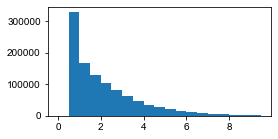

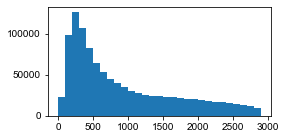

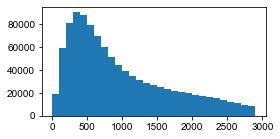

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 24 threads, in 32.985s
-- region kept: 0.8345
- iter:1
- generate reference metrics from picked chrs.
-- multiprocessing process references with 24 threads, in 27.870s
-- collapse all regions into 1d.


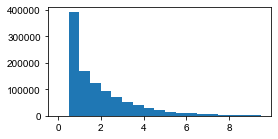

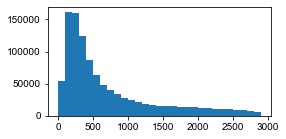

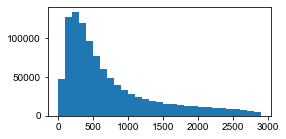

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 24 threads, in 33.310s
-- region kept: 0.9741
- iter:2
- generate reference metrics from picked chrs.
-- multiprocessing process references with 24 threads, in 28.711s
-- collapse all regions into 1d.


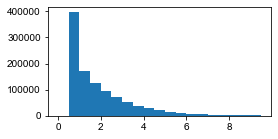

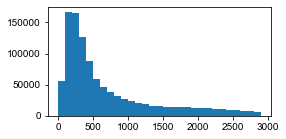

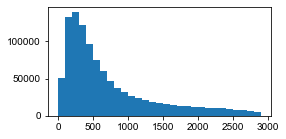

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 24 threads, in 33.855s
-- region kept: 0.9929
- iter:3
- generate reference metrics from picked chrs.
-- multiprocessing process references with 24 threads, in 28.114s
-- collapse all regions into 1d.


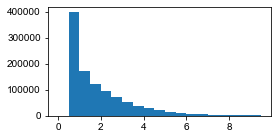

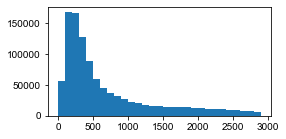

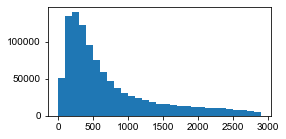

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 24 threads, in 33.771s
-- region kept: 0.9963


In [8]:
# load functions
reload(ia.spot_tools.picking)
from ImageAnalysis3.spot_tools.picking import Pick_spots_by_intensity, EM_pick_scores_in_population, generate_reference_from_population,evaluate_differences

%matplotlib inline
niter= 10
nkeep = len(sel_dna_cand_hzxys_list)
num_threads = fov.num_threads
# initialize
init_dna_hzxys = Pick_spots_by_intensity(sel_dna_cand_hzxys_list[:nkeep])
# set save list
sel_dna_hzxys_list, sel_dna_scores_list, all_dna_scores_list = [init_dna_hzxys], [], []
for _iter in range(niter):
    print(f"- iter:{_iter}")
    # generate reference
    ref_ct_dists, ref_local_dists, ref_ints = generate_reference_from_population(
        sel_dna_hzxys_list[-1], dna_reg_ids, 
        sel_dna_hzxys_list[-1][:nkeep], dna_reg_ids,
        num_threads=num_threads,
        collapse_regions=True,
    )
    plt.figure(figsize=(4,2))
    plt.hist(np.ravel(ref_ints), bins=np.arange(0,10,0.5))
    plt.figure(figsize=(4,2))
    plt.hist(np.ravel(ref_ct_dists), bins=np.arange(0,3000,100))
    plt.figure(figsize=(4,2))
    plt.hist(np.ravel(ref_local_dists), bins=np.arange(0,3000,100))
    plt.show()
    # scoring
    sel_hzxys, sel_scores, all_scores = EM_pick_scores_in_population(
            sel_dna_cand_hzxys_list[:nkeep], dna_reg_ids, sel_dna_hzxys_list[-1], 
            ref_ct_dists, ref_local_dists, ref_ints,
            sel_dna_hzxys_list[-1], dna_reg_ids, num_threads=num_threads,
        )
    update_rate = evaluate_differences(sel_hzxys, sel_dna_hzxys_list[-1])
    print(f"-- region kept: {update_rate:.4f}")
    sel_dna_hzxys_list.append(sel_hzxys)
    sel_dna_scores_list.append(sel_scores)
    all_dna_scores_list.append(all_scores)
    
    if update_rate > 0.995:
        break

<IPython.core.display.Javascript object>


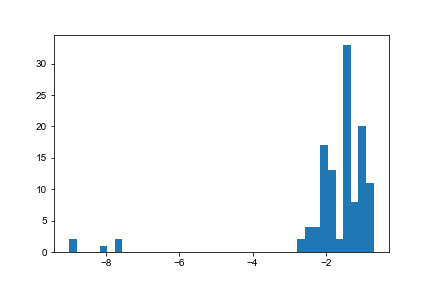

E:\Users\puzheng\AppData\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
E:\Users\puzheng\AppData\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


In [27]:
plt.figure()
plt.hist(np.log(sel_dna_scores_list[sel_iter][1]), 40)
plt.show()

In [29]:
from scipy.spatial.distance import pdist, squareform
sel_iter = -1

final_dna_hzxys_list = []
distmap_list = []
score_th = np.exp(-2.5)
bad_spot_percentage = 0.5
for _hzxys, _scores in zip(sel_dna_hzxys_list[sel_iter], sel_dna_scores_list[sel_iter]):
    _kept_hzxys = np.array(_hzxys).copy()
    _kept_hzxys[_scores < score_th] = np.nan
    if np.mean(np.isnan(_kept_hzxys).sum(1)>0)<bad_spot_percentage:
        final_dna_hzxys_list.append(_kept_hzxys)
        distmap_list.append(squareform(pdist(_kept_hzxys[:,1:4])))

distmap_list = np.array(distmap_list)
median_distmap = np.nanmedian(distmap_list, axis=0)

E:\Users\puzheng\AppData\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


0.2789205730596114


<IPython.core.display.Javascript object>


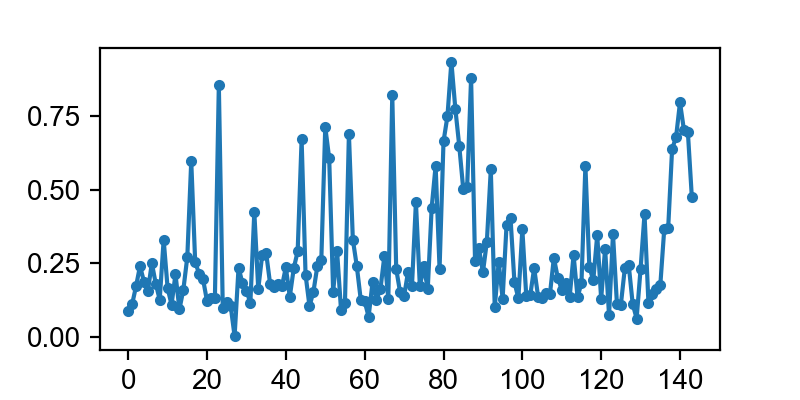

In [30]:
loss_rates = np.mean(np.sum(np.isnan(final_dna_hzxys_list), axis=2)>0, axis=0)
print(np.mean(loss_rates))
fig, ax = plt.subplots(figsize=(4,2),dpi=200)
ax.plot(loss_rates, '.-')
ax.set_xticks(np.arange(0,150,20))
plt.show()

In [25]:
kept_inds = np.where(loss_rates<0.4)[0]

<IPython.core.display.Javascript object>


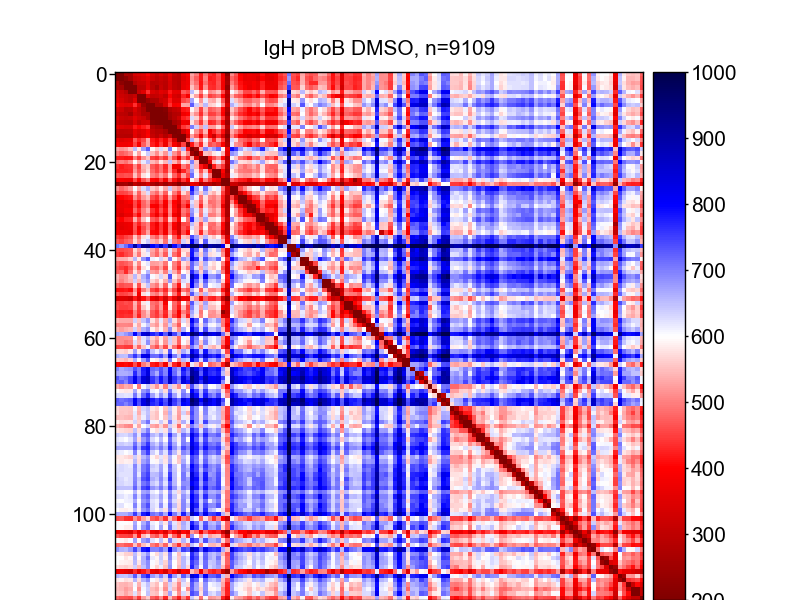

In [31]:
fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(#median_distmap,
                                               median_distmap[kept_inds][:,kept_inds], 
                                               color_limits=[200,1000],
                                               ax=ax,
                                               ticks=np.arange(0,150,20), 
                                               figure_dpi=200)
ax.set_title(f"IgH proB DMSO, n={len(distmap_list)}", fontsize=7.5)
plt.show()

## visualize single example

<IPython.core.display.Javascript object>


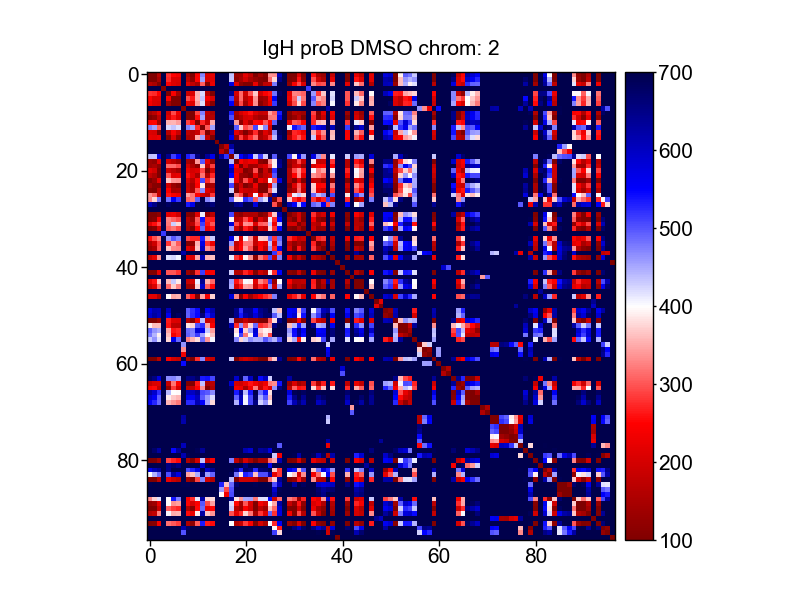

<IPython.core.display.Javascript object>


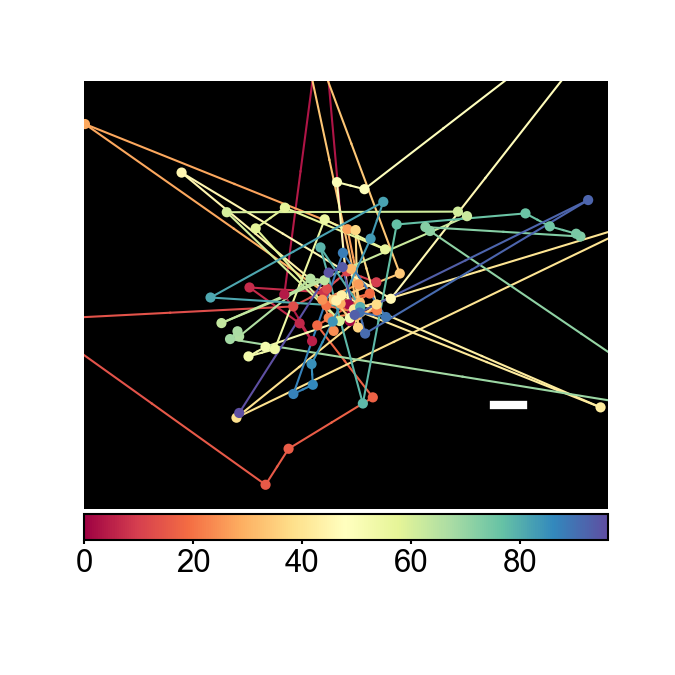

-- add colorbar with colornorm: <matplotlib.colors.Normalize object at 0x0000024F1741DB08>


In [34]:
%matplotlib notebook

chrom_id = 2

valid_inds = np.where(np.isnan(final_dna_hzxys_list[chrom_id]).sum(1) == 0)[0]

fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(#distmap_list[chrom_id],
                                               distmap_list[chrom_id][valid_inds][:,valid_inds], 
                                               color_limits=[100,700],
                                               ax=ax,
                                               ticks=np.arange(0,150,20), 
                                               figure_dpi=200)
ax.set_title(f"IgH proB DMSO chrom: {chrom_id}", fontsize=7.5)
plt.gcf().subplots_adjust(bottom=0.1)
plt.show()



reload(figure_tools.image)
ax3d = figure_tools.image.chromosome_structure_3d_rendering(#final_dna_hzxys_list[chrom_id][:,1:], 
                                                     final_dna_hzxys_list[chrom_id][valid_inds, 1:], 
                                                     marker_edge_line_width=0,
                                                     reference_bar_length=100, image_radius=400, 
                                                     line_width=0.5, figure_dpi=300, depthshade=False)
plt.show()

# quality check

In [125]:
with h5py.File(fov.save_filename, "r", libver='latest') as _f:
    _grp = _f['unique']
    _ind = list(_grp['ids'][:]).index(41)
    _im = _grp['ims'][_ind]
    sel_drifts = _grp['drifts'][:,:]
    sel_flags = _grp['flags'][:]
    sel_ids = _grp['ids'][:]
    sel_spots = _grp['spots'][:,:,:]
    print(_ind, np.sum(_grp['spots'][1]))

0 3826469.0


In [58]:
fov.unique_spots_list[100]

array([[ 6.56082726e+00,  2.59606991e+01,  6.11601379e+02, ...,
         7.73071229e-01, -3.07731796e-02,  1.70267914e+02],
       [ 4.22157383e+00,  2.32151070e+01,  9.43703918e+02, ...,
         4.81479615e-01,  6.38460398e-01,  1.23589035e+02],
       [ 3.96723986e+00,  2.77801933e+01,  7.93457642e+02, ...,
         7.53727496e-01,  9.04093564e-01,  1.02488930e+02],
       ...,
       [ 1.36868820e-01,  2.36938343e+01,  5.36140991e+02, ...,
         1.00000000e+00,  1.00000000e+00,  3.58169556e+01],
       [ 1.75873071e-01,  1.39472771e+01,  1.97251758e+03, ...,
        -2.08728582e-01, -6.80764616e-02,  3.75798035e+01],
       [ 1.79312319e-01,  2.28999996e+01,  8.71613098e+02, ...,
        -1.00000000e+00, -1.00000000e+00,  3.54034157e+01]], dtype=float32)

<IPython.core.display.Javascript object>


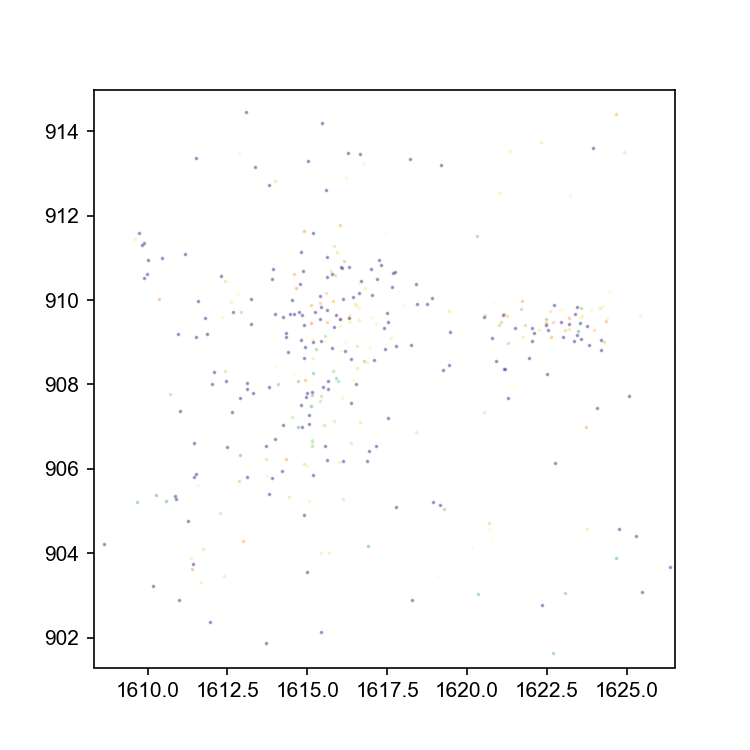

In [145]:
%matplotlib notebook
from matplotlib.cm import Spectral
plt.figure(figsize=(5,5),dpi=150)
for _id,_s in zip(sel_ids, kept_spots_list):
    plt.plot(_s[:,2],_s[:,3], '.', label=f'{_id}', 
             markersize=1.5, color=Spectral(_id/len(sel_ids)), alpha=0.5)
#plt.legend()
plt.ylim([0,2048])
plt.xlim([0,2048])
#plt.legend()
plt.show()

array([[0.98592849, 0.63737024, 0.35963091, 1.        ],
       [0.98869666, 0.65736255, 0.36885813, 1.        ],
       [0.99146482, 0.67735486, 0.37808535, 1.        ],
       [0.99238754, 0.69388697, 0.39008074, 1.        ],
       [0.99269512, 0.70926567, 0.40299885, 1.        ],
       [0.9928489 , 0.71695502, 0.4094579 , 1.        ],
       [0.99315648, 0.73233372, 0.42237601, 1.        ],
       [0.99346405, 0.74771242, 0.43529412, 1.        ],
       [0.99377163, 0.76309112, 0.44821223, 1.        ],
       [0.99392541, 0.77078047, 0.45467128, 1.        ],
       [0.99423299, 0.78615917, 0.46758939, 1.        ],
       [0.99454056, 0.80153787, 0.4805075 , 1.        ],
       [0.99484814, 0.81691657, 0.49342561, 1.        ],
       [0.99515571, 0.83229527, 0.50634371, 1.        ],
       [0.9953095 , 0.83998462, 0.51280277, 1.        ],
       [0.99561707, 0.85536332, 0.52572088, 1.        ],
       [0.99592464, 0.87074202, 0.53863899, 1.        ],
       [0.99638601, 0.88796617,

## visualize pciked hzxys

<IPython.core.display.Javascript object>


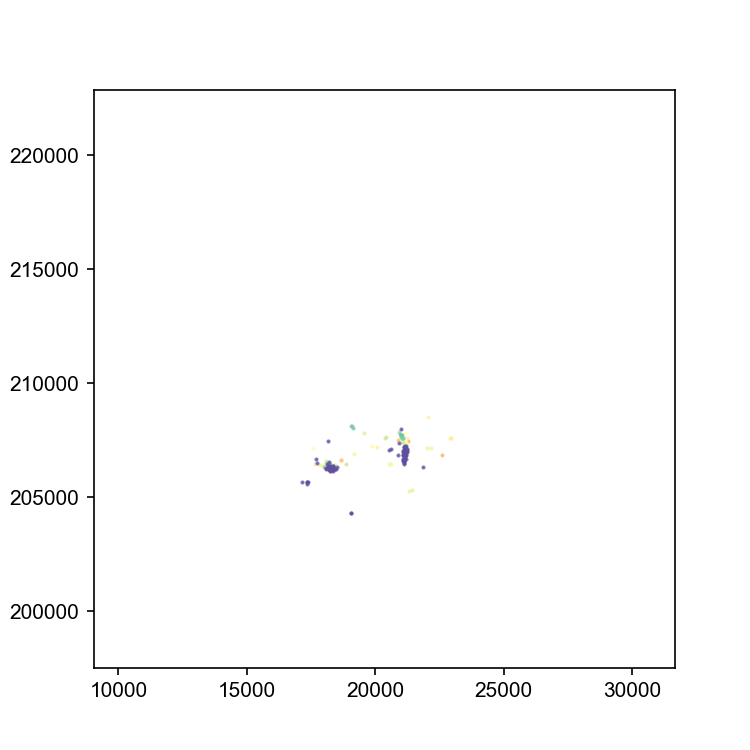

In [146]:
%matplotlib notebook
from matplotlib.cm import Spectral
plt.figure(figsize=(5,5),dpi=150)

for _i, _id in enumerate(sel_ids):
    plt.plot([_spots[_i,2] for _spots in final_dna_hzxys_list],
             [_spots[_i,3] for _spots in final_dna_hzxys_list],
             '.', markersize=2, color=Spectral(_id/(len(sel_ids)+1)), alpha=0.7)
#for _id,_s in zip(sel_ids, kept_spots_list):
#    plt.plot(_s[:,2],_s[:,3], '.', label=f'{_id}', 
#             markersize=1.5, color=Spectral(_id/len(sel_ids)), alpha=0.5)
#plt.legend()
#plt.ylim([0,2048])
#plt.xlim([0,2048])
#plt.legend()
plt.show()

## visualize fitted spots

<IPython.core.display.Javascript object>


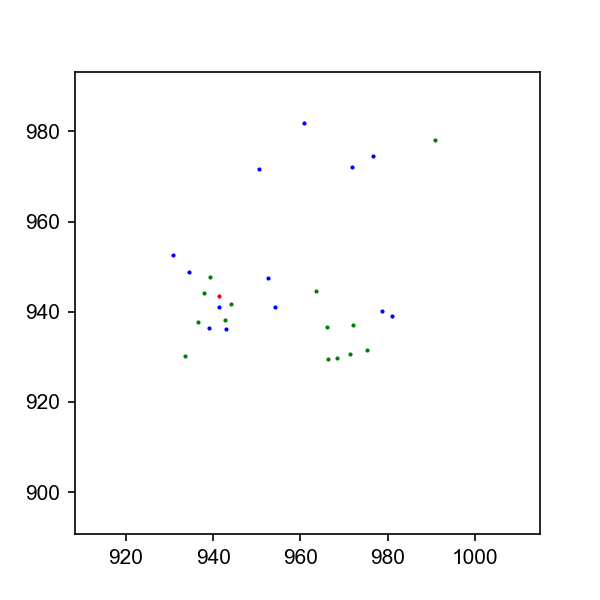

In [28]:
plt.figure(figsize=(4,4),dpi=150)
plt.plot(fov.chrom_coords[:,1], fov.chrom_coords[:,2], 'r.', markersize=2)
plt.plot(fov.unique_spots_list[0][:,2], fov.unique_spots_list[0][:,3], 'b.', markersize=2)
plt.plot(fov.unique_spots_list[-1][:,2], fov.unique_spots_list[-1][:,3], 'g.', markersize=2)

In [84]:
sel_drifts[kept_inds]

array([[ 2.670e+00,  6.750e+00, -2.800e-01],
       [ 2.670e+00,  6.750e+00, -2.800e-01],
       [ 2.660e+00,  3.018e+01,  0.000e+00],
       [ 2.660e+00,  3.018e+01,  0.000e+00],
       [ 2.580e+00,  3.860e+00,  2.620e+00],
       [ 2.580e+00,  3.860e+00,  2.620e+00],
       [ 2.570e+00, -4.690e+00,  2.610e+00],
       [ 2.570e+00, -4.690e+00,  2.610e+00],
       [ 2.540e+00,  5.300e-01,  2.060e+00],
       [ 2.540e+00,  5.300e-01,  2.060e+00],
       [ 2.600e+00,  2.336e+01,  4.000e-02],
       [ 2.600e+00,  2.336e+01,  4.000e-02],
       [ 2.570e+00,  2.933e+01,  1.000e-02],
       [ 2.570e+00,  2.933e+01,  1.000e-02],
       [ 2.560e+00,  2.841e+01, -1.500e-01],
       [ 2.560e+00,  2.841e+01, -1.500e-01],
       [ 2.510e+00,  2.522e+01, -1.100e-01],
       [ 2.510e+00,  2.522e+01, -1.100e-01],
       [ 2.560e+00,  2.280e+01, -2.500e-01],
       [ 2.560e+00,  2.280e+01, -2.500e-01],
       [ 2.560e+00,  2.134e+01, -2.200e-01],
       [ 2.560e+00,  2.134e+01, -2.200e-01],
       [ 2

In [86]:
sel_drifts[kept_inds]

array([[  0.46, -16.34,  16.85],
       [  0.46, -16.34,  16.85],
       [  0.44,  -8.16,  14.05],
       [  0.44,  -8.16,  14.05],
       [  2.29,  -2.57,  15.59],
       [  2.29,  -2.57,  15.59],
       [  2.35,   8.53,  14.83],
       [  2.35,   8.53,  14.83],
       [  2.31,   6.76,  13.09],
       [  2.31,   6.76,  13.09],
       [  0.44, -15.23,  17.16],
       [  0.44, -15.23,  17.16],
       [  2.33, -16.8 ,  17.91],
       [  2.33, -16.8 ,  17.91],
       [  0.46, -16.95,  17.39],
       [  0.46, -16.95,  17.39],
       [  0.44, -18.39,  20.26],
       [  0.44, -18.39,  20.26],
       [  0.42, -18.18,  18.52],
       [  0.42, -18.18,  18.52],
       [  0.41, -18.32,  17.25],
       [  0.41, -18.32,  17.25],
       [  0.41, -17.91,  18.16],
       [  0.41, -17.91,  18.16],
       [  0.41, -18.92,  17.75],
       [  0.41, -18.92,  17.75],
       [  0.41, -18.62,  16.99],
       [  0.41, -18.62,  16.99],
       [  0.42, -18.41,  17.88],
       [  0.42, -18.41,  17.88],
       [  

In [93]:
fov.fov_id

5

In [118]:
pickle.load(open(fov.drift_filename, 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: '\\\\10.245.74.158\\Chromatin_NAS_6\\20201002-B_dox-IAA-STI+_CTP-08_IgH\\Analysis\\drift\\Conv_zscan_05_current_cor.pkl'

In [101]:
bead_im, _ = io_tools.load.correct_fov_image(os.path.join(fov.data_folder[0], 'H29R29\\Conv_zscan_05.dax'), 
                                             [fov.channels[fov.bead_channel_index]],
                                             correction_folder=fov.correction_folder,
                                             single_im_size=fov.shared_parameters['single_im_size'],
                                             all_channels=fov.channels,
                                             illumination_corr=True, 
                                             warp_image=False, calculate_drift=False, return_drift=False,
                                             verbose=True,
                                             )

- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\H29R29\Conv_zscan_05.dax
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\H29R29\Conv_zscan_05.dax  in 8.028s
-- removing hot pixels for channels:['488'] in 7.301s
-- illumination correction for channels: 488, in 1.663s
-- generate translation function for chromatic correction for channels: [] and drift:[0. 0. 0.] in 0.001s
-- finish correction in 17.336s


In [109]:
correction_tools.alignment.cross_correlation_align_single_image(bead_im[0], fov.ref_im,
                                                                single_im_size=fov.shared_parameters['single_im_size'])

-- aligning image -> directly use image
-- directly use ref_image


array([-0.09, -9.87,  6.47])

<IPython.core.display.Javascript object>


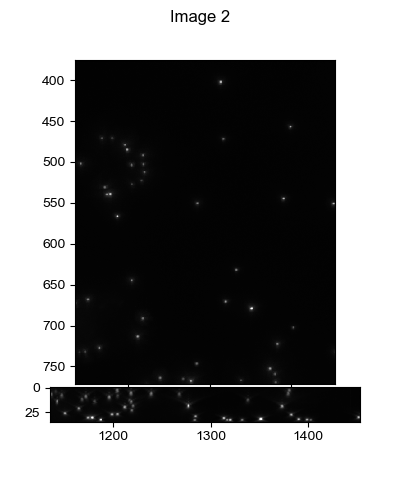

In [106]:
visual_tools.imshow_mark_3d_v2([bead_im[0], fov.ref_im])